In [121]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.signal import butter, lfilter, freqz

from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:ylabel='VEL'>

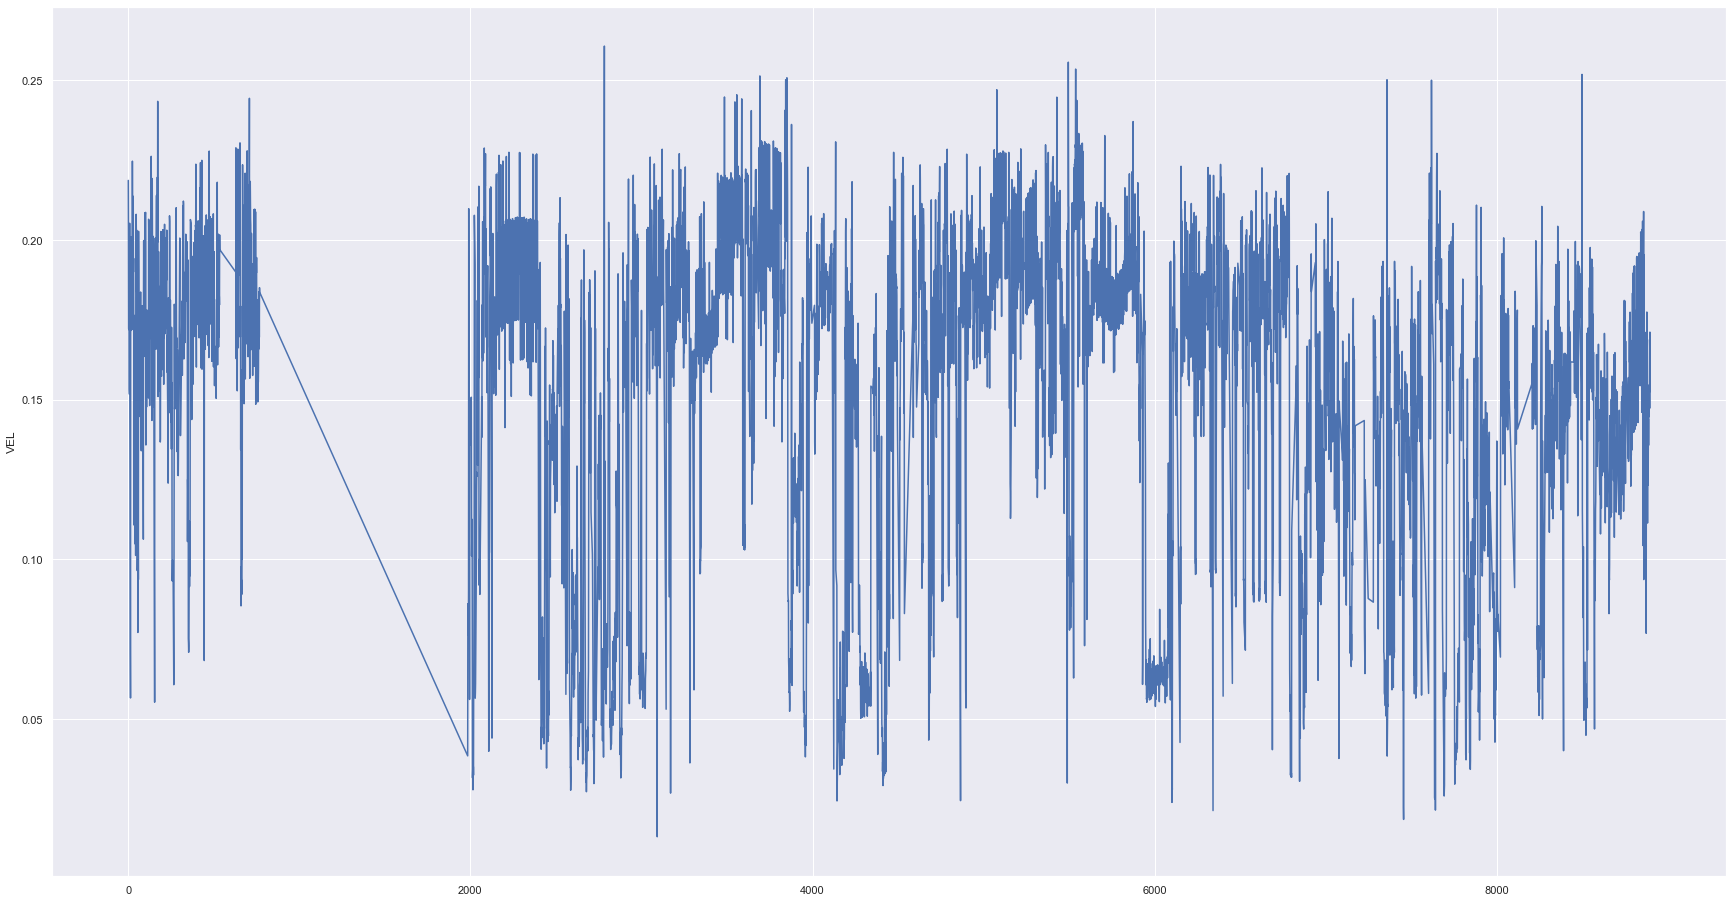

In [122]:
import pickle
import seaborn as sns

sns.set(rc = {'figure.figsize':(30, 16)})
with open('velocities.pkl', 'rb') as f:
    velocities = pickle.load(f)

data = pd.DataFrame(columns=['VEL'], data=velocities)

plot_data = data
sns.lineplot(data=plot_data, x=plot_data.index, y='VEL')

In [123]:
data['VEL'].describe()

count    6578.000000
mean        0.154232
std         0.050151
min         0.013135
25%         0.126006
50%         0.170685
75%         0.190130
max         0.260719
Name: VEL, dtype: float64

In [124]:
sns.set(rc = {'figure.figsize':(30, 16)})
data = pd.read_csv('data.tsv', sep='\t')

data = data[['Gaze point X',
             'Gaze point Y',
             'Gaze point 3D X',
             'Gaze point 3D Y',
             'Gaze point 3D Z',             
             'Gaze direction right X',
             'Gaze direction right Y',
             'Gaze direction right Z',
             'Gaze direction left X',
             'Gaze direction left Y',
             'Gaze direction left Z',
             'Pupil position left X',
             'Pupil position left Y',
             'Pupil position left Z',
             'Pupil position right X',
             'Pupil position right Y',
             'Pupil position right Z',
             'Pupil diameter left',
             'Eye movement type',
             'Computer timestamp']]

data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data['Computer timestamp'] = (data['Computer timestamp'] / 1000) / 1000

In [125]:
data['GAZE_DIR_AVG_X'] = (data['Gaze direction right X'] + data['Gaze direction left X']) / 2
data['GAZE_DIR_AVG_Y'] = (data['Gaze direction right Y'] + data['Gaze direction left Y']) / 2
data['GAZE_DIR_AVG_Z'] = (data['Gaze direction right Z'] + data['Gaze direction left Z']) / 2

data['VECTOR1_X'] = data['GAZE_DIR_AVG_X']
data['VECTOR1_Y'] = data['GAZE_DIR_AVG_Y']
data['VECTOR1_Z'] = data['GAZE_DIR_AVG_Z']

data['VECTOR2_X'] = data['GAZE_DIR_AVG_X'].shift(1)
data['VECTOR2_Y'] = data['GAZE_DIR_AVG_Y'].shift(1)
data['VECTOR2_Z'] = data['GAZE_DIR_AVG_Z'].shift(1)

# arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

data['ANGLE'] = np.arccos((data['VECTOR1_X'] * data['VECTOR2_X'] + data['VECTOR1_Y'] * data['VECTOR2_Y'] + data['VECTOR1_Z'] * data['VECTOR2_Z']) \
/ (np.sqrt(data['VECTOR1_X'] ** 2 + data['VECTOR1_Y'] ** 2 + data['VECTOR1_Z'] ** 2) * np.sqrt(data['VECTOR2_X'] ** 2 + data['VECTOR2_Y'] ** 2 + data['VECTOR2_Z'] ** 2)))


data['T_DIFF'] = data['Computer timestamp'] - data['Computer timestamp'].shift(1)

data['ANGLE_VEL'] = data['ANGLE'] / data['T_DIFF']

data.drop(0, inplace=True)
data.reset_index(inplace=True)

data['colors'] = data['Eye movement type']
data['colors'] = data['colors'].replace('Fixation', 'blue')
data['colors'] = data['colors'].replace('Saccade', 'red')
data['colors'] = data['colors'].replace('Unclassified', 'green')

In [142]:
data['ANGLE_VEL'].describe()

count    43815.000000
mean         0.587420
std          1.120663
min          0.000799
25%          0.088739
50%          0.204997
75%          0.535571
max         18.957906
Name: ANGLE_VEL, dtype: float64

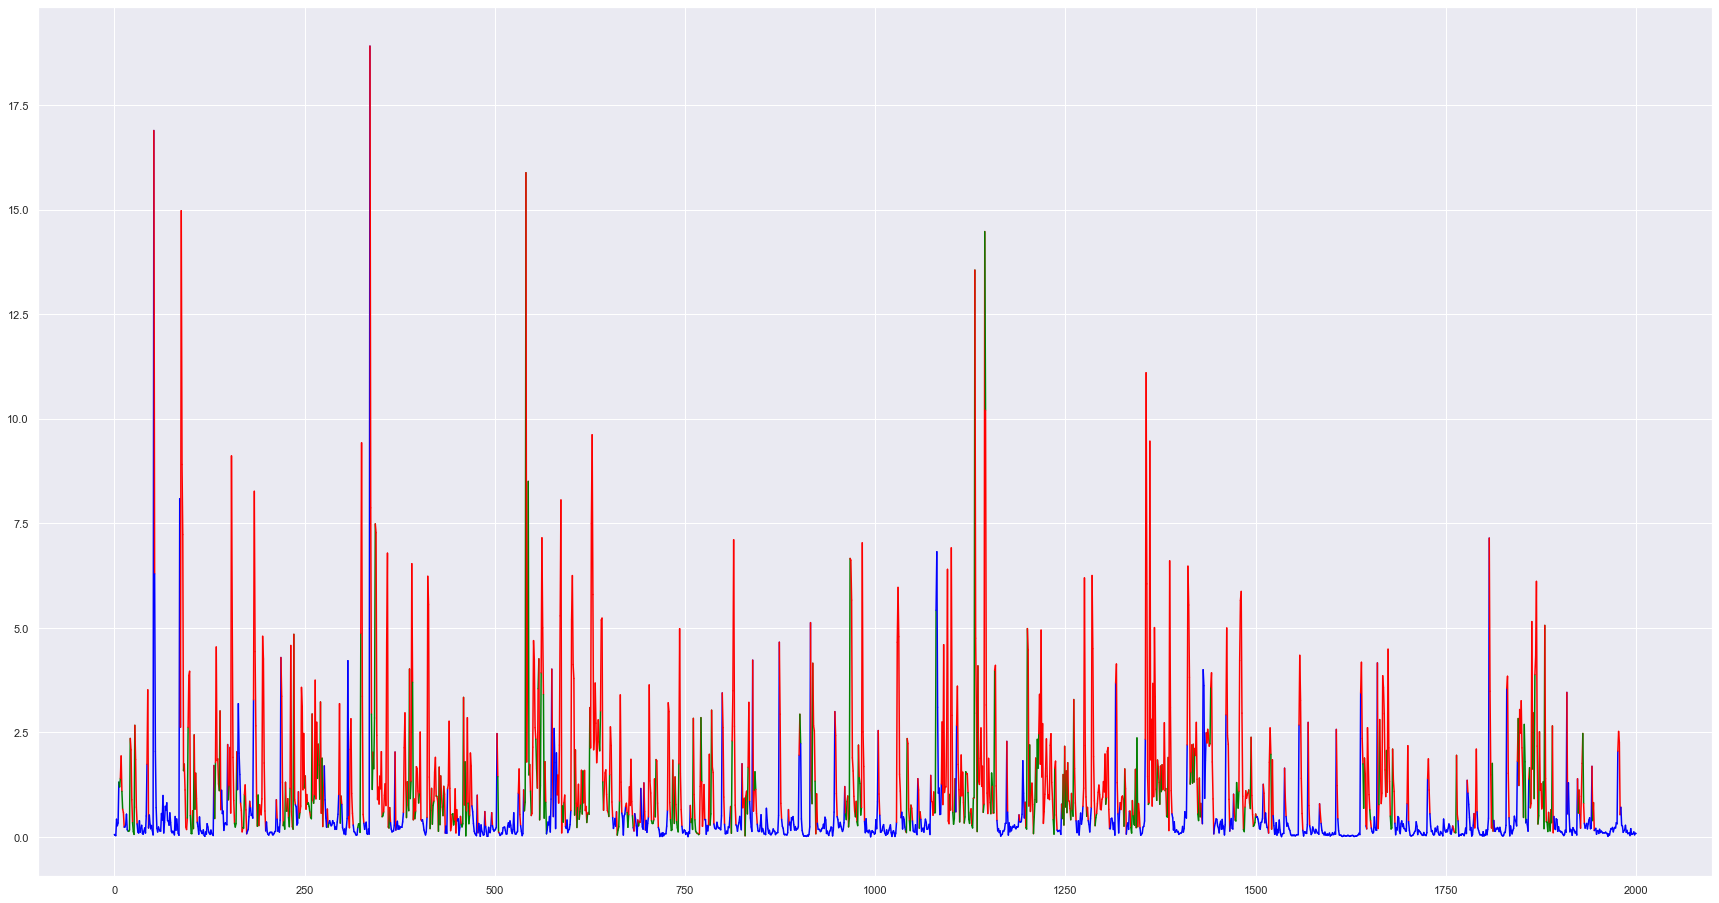

In [127]:
plot_data = data.loc[0:2000]
plot_data.reset_index(inplace=True, drop=True)

for idx, row in plot_data.iterrows():
    if idx + 2 > len(plot_data):
        break
    sns.lineplot([idx, idx+1], [row['ANGLE_VEL'], plot_data.loc[idx+1, 'ANGLE_VEL']], color=row['colors'])

In [128]:
data['PRED_TYPE'] = np.where(data['ANGLE_VEL'] < 0.8, 'Fixation', 'Saccade')
print(classification_report(data['Eye movement type'], data['PRED_TYPE']))

              precision    recall  f1-score   support

    Fixation       0.84      0.99      0.91     30611
     Saccade       0.89      0.69      0.78     10033
Unclassified       0.00      0.00      0.00      3171

    accuracy                           0.85     43815
   macro avg       0.58      0.56      0.56     43815
weighted avg       0.79      0.85      0.81     43815



<AxesSubplot:xlabel='count', ylabel='Eye movement type'>

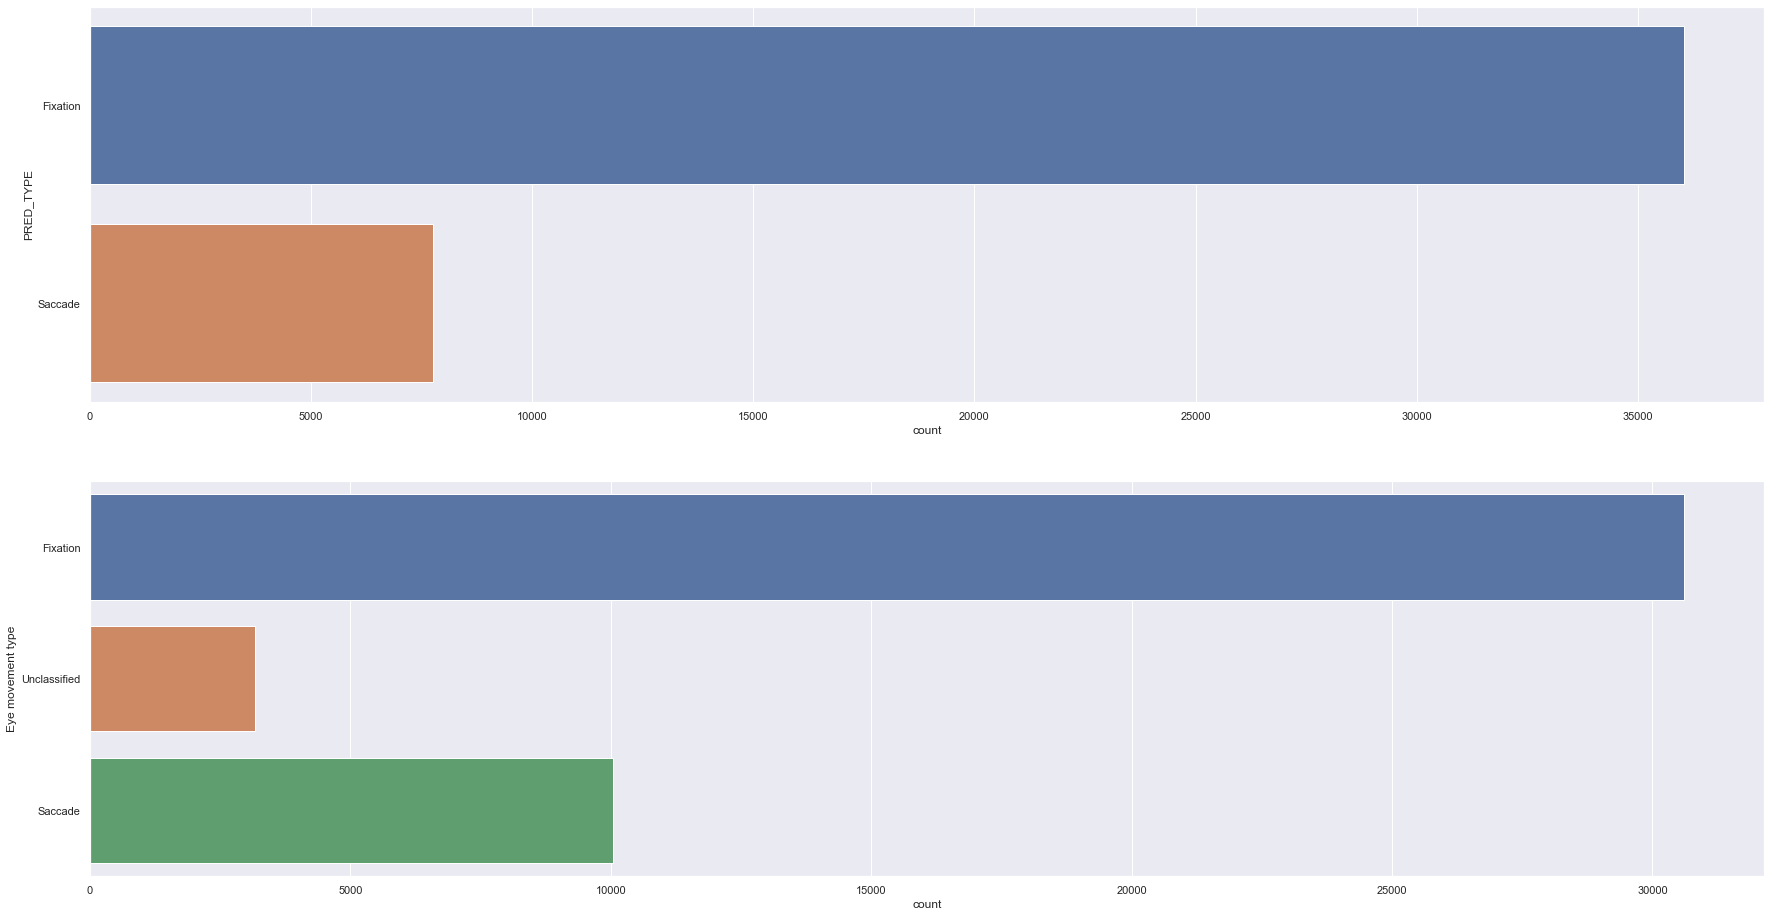

In [129]:
plt.subplot(2, 1, 1)
sns.countplot(data=data, y='PRED_TYPE')
plt.subplot(2, 1, 2)
sns.countplot(data=data, y='Eye movement type')

In [130]:
# fixation_count = len(data[data['Eye movement type'] == 'Fixation'])
# saccade_count = len(data[data['Eye movement type'] == 'Saccade'])
# total = len(data['Eye movement type'])

In [131]:
# import tensorflow as tf

# from keras.models import Sequential
# from keras.layers import *
# import keras

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [132]:
# scaler = StandardScaler()
# for col in data.columns:

#     if col in ['Eye movement type', 'Recording timestamp']:
#         continue
    
#     data[col] = scaler.fit_transform([data[col]])[0]


# data['Eye movement type'] = data['Eye movement type'].replace('Fixation', 1)
# data['Eye movement type'] = data['Eye movement type'].replace('Saccade', 0)
# Y = data['Eye movement type'] = data['Eye movement type'].replace('Fixation', 0)
# X = data.drop(['Eye movement type', 'Recording timestamp'], axis=1).to_numpy()

In [133]:
# X_sequences = []
# Y_sequences = []

# seq_length = 15
# len_features = len(X[0])

# for i in range(seq_length, len(X)):

#     if i + seq_length > len(X):
#         break

#     X_sequences.append(X[i-seq_length:i])
#     Y_sequences.append(Y[i])a

# np.shape(X_sequences), np.shape(Y_sequences)

In [134]:
# X_train, X_test, y_train, y_test = train_test_split(X_sequences, Y_sequences, test_size=0.25)

# X_train, y_train = np.array(X_train), np.array(y_train)
# X_test, y_test = np.array(X_test), np.array(y_test)

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len_features))
# # y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 3))

# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len_features))
# # y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 3))

# np.shape(X_train), np.shape(y_train), np.shape(X_test), np.shape(y_test)

In [135]:
# lr = 3e-5

# weight_for_0 = (1 / saccade_count) * (total / 2.0)
# weight_for_1 = (1 / fixation_count) * (total / 2.0)

# class_weight = {0: weight_for_0, 1: weight_for_1}


# model = Sequential()
# model.add(LSTM(units=256, activation='relu', return_sequences=False, input_shape=(seq_length, len_features)))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss = 'binary_crossentropy', metrics=['Accuracy', keras.metrics.AUC(name='prc', curve='PR')])
# model.summary()

In [136]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_prc', verbose=1, patience=100, mode='max')

In [137]:
# epochs = 200
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=2048, callbacks=[], class_weight=class_weight)

In [138]:
# plt.style.use("ggplot")

# plt.plot(range(len(history.history['Accuracy'])), history.history['Accuracy'])
# plt.plot(range(len(history.history['Accuracy'])), history.history['val_Accuracy'])

# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

In [139]:
# y_pred = model.predict(X_test)
# print(classification_report(y_test, y_pred))